In [10]:
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# LOAD DATA
df = pd.read_csv('Mall_Customers.csv')

# PREPROCESSING
df['Gender'] = LabelEncoder().fit_transform(df['Gender'])
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])


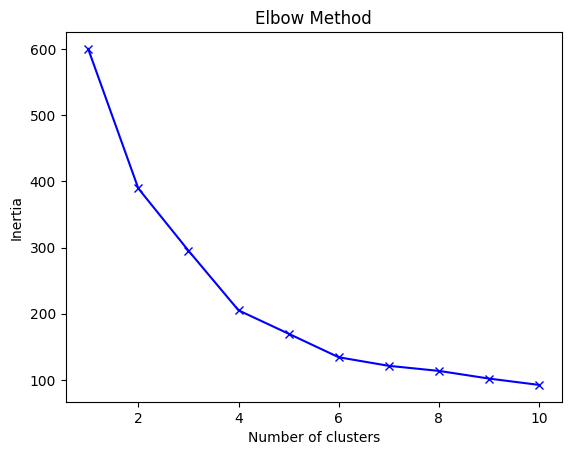

In [11]:
# K-MEANS CLUSTERING
inertia = []
for k in range(1, 11):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(df_scaled)
    inertia.append(km.inertia_)

plt.plot(range(1, 11), inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

kmeans = KMeans(n_clusters=5, random_state=42)
df['KMeans_Cluster'] = kmeans.fit_predict(df_scaled)

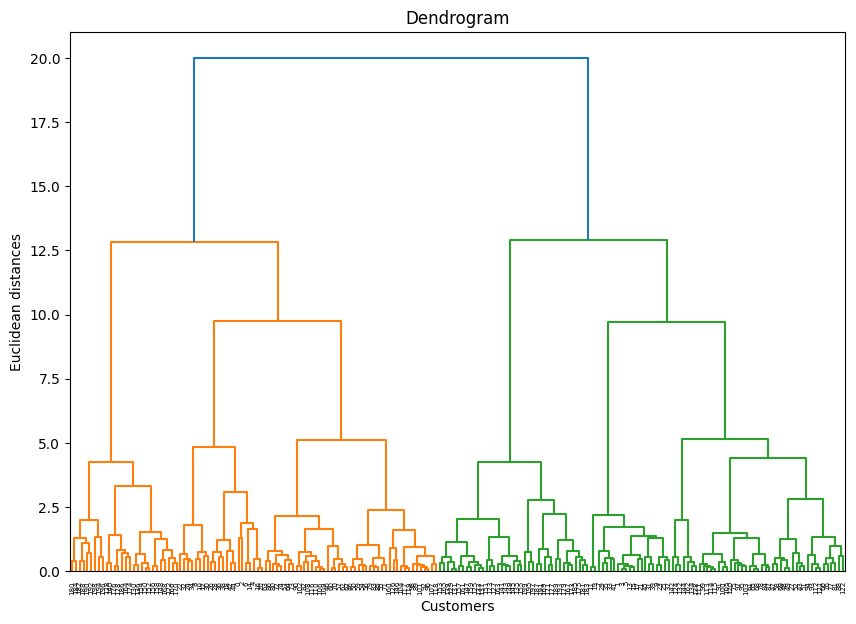

In [12]:
# HIERARCHICAL CLUSTERING
plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(sch.linkage(df_scaled, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

hc = AgglomerativeClustering(n_clusters=5, linkage='ward')
df['Hierarchical_Cluster'] = hc.fit_predict(df_scaled)

In [13]:
# DBSCAN
db = DBSCAN(eps=0.5, min_samples=5)
df['DBSCAN_Cluster'] = db.fit_predict(df_scaled)

In [14]:
# SEGMENT ANALYSIS
segment_summary = df.groupby('KMeans_Cluster')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean()
print(segment_summary)

segment_labels = {
    0: 'Low Spenders',
    1: 'High Value',
    2: 'Young Spenders',
    3: 'Moderate',
    4: 'Careful Spenders'
}
df['Segment_Label'] = df['KMeans_Cluster'].map(segment_labels)

                      Age  Annual Income (k$)  Spending Score (1-100)
KMeans_Cluster                                                       
0               55.275862           47.620690               41.706897
1               32.875000           86.100000               81.525000
2               25.769231           26.115385               74.846154
3               26.733333           54.311111               40.911111
4               44.387097           89.774194               18.483871


In [15]:
# ASSOCIATION RULE MINING BY SEGMENT
df_rules = df.copy()
df_rules['Age'] = pd.cut(df_rules['Age'], bins=[0, 25, 35, 50, 100], labels=['<25', '25-35', '35-50', '50+'])
df_rules['Income'] = pd.cut(df_rules['Annual Income (k$)'], bins=3, labels=['Low', 'Medium', 'High'])
df_rules['Spend'] = pd.cut(df_rules['Spending Score (1-100)'], bins=3, labels=['Low', 'Medium', 'High'])

def get_rules_for_segment(segment_name):
    segment_df = df_rules[df_rules['Segment_Label'] == segment_name]
    transactions = segment_df[['Gender', 'Age', 'Income', 'Spend']].astype(str).values.tolist()
    
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

    frequent_itemsets = apriori(df_encoded, min_support=0.2, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)
    return rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False)

In [16]:
# SHOW RULES FOR EACH SEGMENT
for segment in df['Segment_Label'].unique():
    print(f"\nRules for segment: {segment}")
    print(get_rules_for_segment(segment).head())


Rules for segment: Young Spenders
      antecedents  consequents   support  confidence      lift
50       (0, <25)  (Low, High)  0.307692    0.888889  1.216374
46  (Low, 0, <25)       (High)  0.307692    0.888889  1.216374
21       (0, <25)       (High)  0.307692    0.888889  1.216374
11         (High)        (<25)  0.500000    0.684211  1.111842
41    (Low, High)        (<25)  0.500000    0.684211  1.111842

Rules for segment: Moderate
    antecedents    consequents   support  confidence      lift
14  (Medium, 1)          (<25)  0.244444    0.647059  1.323529
16          (1)  (Medium, <25)  0.244444    0.611111  1.309524
19          (1)  (Low, Medium)  0.244444    0.611111  1.309524
11      (25-35)    (Medium, 0)  0.244444    0.687500  1.289062
0       (25-35)            (0)  0.266667    0.750000  1.250000

Rules for segment: Low Spenders
     antecedents consequents   support  confidence      lift
12  (Low, 35-50)         (0)  0.241379    0.823529  1.447415
22      (Low, 1)       (5

C:\Users\Manish\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


              antecedents      consequents  support  confidence      lift
39      (Medium, 0, High)          (25-35)    0.325    0.866667  1.195402
41  (Medium, 25-35, High)              (0)    0.325    0.650000  1.181818
45              (0, High)  (Medium, 25-35)    0.325    0.619048  1.179138
44        (Medium, 25-35)        (0, High)    0.325    0.619048  1.179138
43            (Medium, 0)    (25-35, High)    0.325    0.812500  1.160714

Rules for segment: Careful Spenders
             antecedents consequents   support  confidence      lift
1                 (High)         (0)  0.225806    0.700000  1.446667
19            (35-50, 1)    (Medium)  0.290323    0.900000  1.268182
17       (Medium, 35-50)         (1)  0.290323    0.642857  1.245536
28  (Low, 35-50, Medium)         (1)  0.225806    0.636364  1.232955
27       (Low, 35-50, 1)    (Medium)  0.225806    0.875000  1.232955


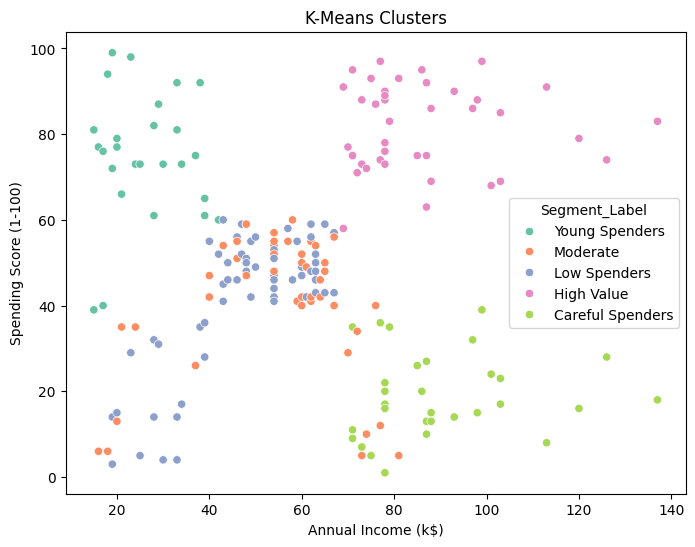

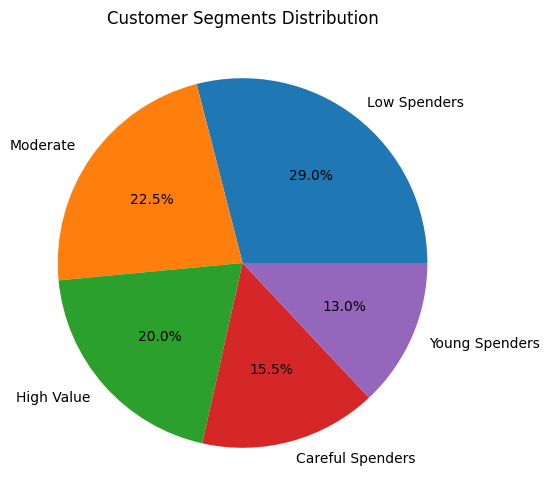

In [17]:

# VISUALIZATION
plt.figure(figsize=(8,6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='Segment_Label', data=df, palette='Set2')
plt.title('K-Means Clusters')
plt.show()

plt.figure(figsize=(6,6))
df['Segment_Label'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title("Customer Segments Distribution")
plt.ylabel("")
plt.show()